In [ ]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 28.1 MB/s eta 0:00:00


In [ ]:
import numpy as np
import scipy.sparse as sp
import torch
import networkx as nx
import torch_geometric as pyg
from torch_geometric.data import Data
import torch_geometric as pyg
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import global_add_pool
import math
import torch.sparse
from torch.nn import Parameter
from torch.nn import Module
import time
import numpy as np
from sklearn.metrics import f1_score
import random
import json
from collections import Counter
from sklearn.model_selection import StratifiedShuffleSplit
from collections import defaultdict

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
root = '/content/drive/My Drive/PPRGNN-Dataset/'

# Load Methods

In [ ]:
def sparse_mx_to_torch_sparse_tensor(sparse_mx, device=None):
    """Convert a scipy sparse matrix to a torch sparse tensor."""
    sparse_mx = sparse_mx.tocoo().astype(np.float32)
    indices = torch.from_numpy(
        np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64))
    values = torch.from_numpy(sparse_mx.data)
    shape = torch.Size(sparse_mx.shape)
    tensor = torch.sparse.FloatTensor(indices, values, shape)
    if device is not None:
        tensor = tensor.to(device)
    return tensor

def load_raw_graph(dataset_str = "amazon-all", self_loops=True, root='dataset/'):
    txt_file = root + dataset_str + '/adj_list.txt'
    graph = {}
    with open(txt_file, 'r') as f:
        cur_idx = 0
        for row in f:
            row = row.strip().split()
            adjs = []
            for j in range(1, len(row)):
                adjs.append(int(row[j]))
            graph[cur_idx] = adjs
            cur_idx += 1
    adj = nx.adjacency_matrix(nx.from_dict_of_lists(graph))
    adj = sparse_mx_to_torch_sparse_tensor(adj).float()
    G = Data(edge_index=adj.coalesce().indices())
    G = pyg.transforms.GCNNorm(add_self_loops=self_loops)(G)
    adj = torch.sparse.FloatTensor(G.edge_index, G.edge_weight, torch.Size(adj.shape))

    return adj

'''
def load_txt_data_v1(dataset_str="amazon-all", portion='0.06', self_loops=True, root='dataset/'):
    adj = load_raw_graph(dataset_str, self_loops, root)
    labels = np.loadtxt(root + dataset_str + '/label.txt')
    # Approximate multi-label labels as single-label
    dominant_labels = torch.argmax(torch.FloatTensor(labels), dim=1).numpy()

    sss = StratifiedShuffleSplit(n_splits=1, train_size=float(portion), test_size=0.1, random_state=42)
    for train_idx, val_idx in sss.split(np.zeros(len(dominant_labels)), dominant_labels):
        idx_train = torch.LongTensor(train_idx)
        idx_val = torch.LongTensor(val_idx)
    # idx_train = list(np.loadtxt(root + dataset_str + '/train_idx-' + str(portion) + '.txt', dtype=int))
    # idx_val = list(np.loadtxt(root + dataset_str + '/test_idx.txt', dtype=int))

    idx_test = list(np.loadtxt(root + dataset_str + '/test_idx.txt', dtype=int))

    with open(root + dataset_str + '/meta.txt', 'r') as f:
        num_nodes, num_class = [int(w) for w in f.readline().strip().split()]

    features = sp.identity(num_nodes)

    # porting to pytorch
    features = sparse_mx_to_torch_sparse_tensor(features).float()
    labels = torch.FloatTensor(labels)
    # labels = torch.max(labels, dim=1)[1]
    idx_train = torch.LongTensor(idx_train)
    idx_val = torch.LongTensor(idx_val)
    idx_test = torch.LongTensor(idx_test)

    return adj, features, labels, idx_train, idx_val, idx_test, num_nodes, num_class
'''

'''
def load_txt_data_v1(dataset_str="amazon-all", portion='0.06', self_loops=True, root='dataset/'):
    import numpy as np
    import torch
    import scipy.sparse as sp
    from collections import defaultdict

    adj = load_raw_graph(dataset_str, self_loops, root)

    # Load all labels and convert to single-label (dominant class)
    labels = np.loadtxt(root + dataset_str + '/label.txt')
    dominant_labels = torch.argmax(torch.FloatTensor(labels), dim=1).numpy()
    total_nodes = len(dominant_labels)

    # Determine total number of training samples based on portion
    portion = float(portion)
    total_target = int(total_nodes * portion)

    # Build class-to-index mapping
    class_indices = defaultdict(list)
    for idx, label in enumerate(dominant_labels):
        class_indices[label].append(idx)

    num_classes = len(class_indices)
    available_classes = [cls for cls in class_indices if len(class_indices[cls]) > 0]
    num_available_classes = len(available_classes)

    # Compute uniform sample size per class (subject to availability)
    per_class_quota = total_target // num_available_classes

    selected_train_indices = []
    for label in sorted(available_classes):
        indices = class_indices[label]
        if len(indices) >= per_class_quota:
            chosen = np.random.choice(indices, per_class_quota, replace=False)
        else:
            chosen = indices  # Use all available if fewer than quota
        selected_train_indices.extend(chosen)

    # If too few total samples due to small classes, fill up randomly
    if len(selected_train_indices) < total_target:
        remaining = total_target - len(selected_train_indices)
        all_remaining_indices = list(set(range(total_nodes)) - set(selected_train_indices))
        np.random.shuffle(all_remaining_indices)
        selected_train_indices.extend(all_remaining_indices[:remaining])

    idx_train = torch.LongTensor(np.array(selected_train_indices))
    idx_val = torch.LongTensor(np.loadtxt(root + dataset_str + '/test_idx.txt', dtype=int))
    idx_test = torch.LongTensor(np.loadtxt(root + dataset_str + '/test_idx.txt', dtype=int))

    with open(root + dataset_str + '/meta.txt', 'r') as f:
        num_nodes, num_class = [int(w) for w in f.readline().strip().split()]

    # Use identity matrix as features
    features = sp.identity(num_nodes)
    features = sparse_mx_to_torch_sparse_tensor(features).float()
    labels = torch.FloatTensor(labels)

    return adj, features, labels, idx_train, idx_val, idx_test, num_nodes, num_class
'''


def load_txt_data(dataset_str="amazon-all", portion = '0.06' , self_loops=True, root='dataset/'):
    adj = load_raw_graph(dataset_str, self_loops, root)
    idx_train = list(np.loadtxt(root + dataset_str + '/train_idx-' + str(portion) + '.txt', dtype=int))
    idx_val = list(np.loadtxt(root + dataset_str + '/test_idx.txt', dtype=int))
    idx_test = list(np.loadtxt(root + dataset_str + '/test_idx.txt', dtype=int))
    labels = np.loadtxt(root + dataset_str + '/label.txt')

    with open(root + dataset_str + '/meta.txt', 'r') as f:
        num_nodes, num_class = [int(w) for w in f.readline().strip().split()]

    features = sp.identity(num_nodes)
    # print(idx_train)
    # porting to pytorch
    features = sparse_mx_to_torch_sparse_tensor(features).float()
    labels = torch.FloatTensor(labels)
    print(labels.sum(dim=1))  # If sum > 1 for some rows, it's multi-label
    #‌print(labels[0])
    # print(labels)
    # labels = torch.max(labels, dim=1)[1]
    idx_train = torch.LongTensor(idx_train)
    idx_val = torch.LongTensor(idx_val)
    idx_test = torch.LongTensor(idx_test)

    return adj, features, labels, idx_train, idx_val, idx_test, num_nodes, num_class

# Model

In [ ]:
class PPRFunction(torch.autograd.Function):

    @staticmethod
    def forward(ctx, W, B, A, X_0, eps=1):
        X_0 = B if X_0 is None else X_0
        At = torch.transpose(A, 0, 1)
        epsilon = eps
        offset = 5
        X_new, X_prev, i, converge_index = PPRFunction.evaluate(B, W, At, X_0, 0, epsilon, offset)
        ctx.save_for_backward(W, B, A, X_prev)
        ctx.max_index = i
        ctx.epsilon = epsilon
        ctx.offset = offset
        return X_new, converge_index

    @staticmethod
    def evaluate_x_i(B, W, At, X, i, stop_index, epsilon):
        for j in range(i, stop_index - 1, -1):
            X = torch.matmul(W / (1 + (j * epsilon)), X)
            X = torch.spmm(At, X.T).T
            X += B
            X = torch.nn.functional.relu(X)
        return X

    @staticmethod
    def evaluate(B, W, At, X_0, stop_index=0, epsilon=10, offset=5):
        k = 300
        h_stop_index = stop_index + offset
        X_ = B
        for converge_index in range(k):
            X_ = torch.matmul(W / (1 + (converge_index * epsilon)), X_)
            X_ = torch.spmm(At, X_.T).T
            X_ = torch.nn.functional.relu(X_)
            if torch.norm(X_, np.inf) < 3e-6:
                break
        X_prev = PPRFunction.evaluate_x_i(B, W, At, X_0, converge_index + offset, h_stop_index, epsilon)
        X_new = PPRFunction.evaluate_x_i(B, W, At, X_prev, offset - 1, stop_index, epsilon)
        return X_new, X_prev, converge_index + offset, converge_index

    @staticmethod
    def backward(ctx, grad_output, _):
        W, B, A, X = ctx.saved_tensors
        At = torch.transpose(A, 0, 1)
        epsilon = ctx.epsilon
        offset = ctx.offset
        dL_dQ = grad_output
        dL_dW = torch.zeros_like(W)
        dL_dB = torch.zeros_like(B)
        finished = False
        old_offset = 0

        forward_W = W
        backward_W = W.T
        while not finished:
            for i in range(old_offset, offset):
                X_i = PPRFunction.evaluate_x_i(B, forward_W, At, X, i=offset - 1, stop_index=i + 1, epsilon=epsilon)
                Z_i = torch.spmm(At, torch.matmul(forward_W / (1 + i*epsilon), X_i).T).T + B
                dL_dQ_new = (Z_i > 0) * dL_dQ
                dL_dB += dL_dQ_new
                dL_dQ_new = torch.spmm(A / (1 + i*epsilon), dL_dQ_new.T).T
                dL_dW += torch.matmul(dL_dQ_new, X_i.T)
                dL_dQ_new = torch.matmul(backward_W, dL_dQ_new)
                err_q = torch.norm(dL_dQ - dL_dQ_new, np.inf)
                dL_dQ = dL_dQ_new
                if err_q < 1e-5 or i == 5:
                    finished = True
                    break
            if finished:
                break
            else:
                X = PPRFunction.evaluate_x_i(B, W, At, X, i=ctx.max_index + offset, stop_index=offset, epsilon=epsilon)
                old_offset = offset
                offset = offset + ctx.offset
        return dL_dW, dL_dB, None, None, None, None, None, None, None, None, None


In [ ]:
class PPRLayer(Module):
    def __init__(self, in_features, out_features, eps, **kwargs):
        super(PPRLayer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.eps = eps

        self.W = Parameter(torch.FloatTensor(self.out_features, self.out_features))
        self.Omega_1 = Parameter(torch.FloatTensor(self.out_features, self.in_features))
        self.init()

    def init(self):
        stdv = 1. / math.sqrt(self.W.size(1))
        self.W.data.uniform_(-stdv, stdv)
        self.Omega_1.data.uniform_(-stdv, stdv)

    def forward(self, x, A, X_0, *args):
        x = torch.spmm(torch.transpose(x, 0, 1), self.Omega_1.T).T
        x = torch.spmm(torch.transpose(A, 0, 1), x.T).T
        x = PPRFunction.apply(self.W, x, A, X_0, self.eps)
        return x

In [ ]:
class PPRGNN_Amazon(nn.Module):
    def __init__(self, in_dim, h_dim, out_dim, dropout, num_nodes=None, **kwargs):
        super(PPRGNN_Amazon, self).__init__()

        self.conv = PPRLayer(in_dim, h_dim, **kwargs)
        self.dropout = dropout

        self.X_0 = nn.Parameter(torch.zeros(h_dim, num_nodes), requires_grad=False)
        self.V = nn.Linear(h_dim, out_dim, bias=False)

    def forward(self, x, edge_index=None, edge_weight=None, adj=None):
        if adj is None:
            adj = torch.sparse.FloatTensor(edge_index, edge_weight, torch.Size([x.shape[0], x.shape[0]]))
            x = x.T

        x, converge_index = self.conv(x, adj, self.X_0)
        x = F.dropout(x.T, self.dropout, training=self.training)
        x = self.V(x)
        return x, converge_index


class PPRGNN_PPI(nn.Module):
    def __init__(self, in_dim, out_dim, h_dim, **kwargs):
        super(PPRGNN_PPI, self).__init__()
        self.conv1 = PPRLayer(in_dim, 4 * h_dim, **kwargs)
        self.conv2 = PPRLayer(4 * h_dim, 2 * h_dim, **kwargs)
        self.conv3 = PPRLayer(2 * h_dim, 2 * h_dim, **kwargs)
        self.conv4 = PPRLayer(2 * h_dim, h_dim, **kwargs)
        self.conv5 = PPRLayer(h_dim, out_dim, **kwargs)

        self.X_0 = None

        self.V = nn.Linear(h_dim, out_dim)
        self.V_0 = nn.Linear(in_dim, 4 * h_dim)
        self.V_1 = nn.Linear(4 * h_dim, 2 * h_dim)
        self.V_2 = nn.Linear(2 * h_dim, 2 * h_dim)
        self.V_3 = nn.Linear(2 * h_dim, h_dim)

    def forward(self, features, edge_index, edge_weight):
        features = features.T
        adj = torch.sparse.FloatTensor(edge_index, edge_weight, torch.Size([features.shape[1], features.shape[1]]))

        x = features
        x_new, layers1 = self.conv1(x, adj, self.X_0)
        x = F.elu(x_new.T + self.V_0(x.T)).T
        x_new, layers2 = self.conv2(x, adj, self.X_0)
        x = F.elu(x_new.T + self.V_1(x.T)).T
        x_new, layers3 = self.conv3(x, adj, self.X_0)
        x = F.elu(x_new.T + self.V_2(x.T)).T
        x_new, layers4 = self.conv4(x, adj, self.X_0)
        x = F.elu(x_new.T + self.V_3(x.T)).T
        x_new, layers5 = self.conv5(x, adj, self.X_0)
        x = x_new.T + self.V(x.T)
        return x, layers1 + layers2 + layers3 + layers4 + layers5


class PPRGNN_GC(nn.Module):
    def __init__(self, in_dim, h_dim, out_dim, dropout, eps, **kwargs):
        super(PPRGNN_GC, self).__init__()

        self.conv1 = PPRLayer(in_dim, h_dim, eps=eps)
        self.conv2 = PPRLayer(h_dim, h_dim, eps=eps)
        self.conv3 = PPRLayer(h_dim, h_dim, eps=eps)

        self.dropout = dropout
        self.X_0 = None
        self.V_0 = nn.Linear(h_dim, h_dim)
        self.V_1 = nn.Linear(h_dim, out_dim)

    def forward(self, x, adj, batch):
        x, layers1 = self.conv1(x, adj, self.X_0)
        x, layers2 = self.conv2(x, adj, self.X_0)
        x, layers3 = self.conv3(x, adj, self.X_0)
        x = x.T

        x = global_add_pool(x, batch)
        x = F.relu(self.V_0(x))
        x = F.dropout(x, self.dropout, training=self.training)
        x = self.V_1(x)
        return F.log_softmax(x, dim=1), layers1 + layers2 + layers3


class APPNP(nn.Module):
    def __init__(self, in_dim, out_dim, h_dim):
        super(APPNP, self).__init__()
        self.lin1 = pyg.nn.GCNConv(in_dim, h_dim, normalize=False)
        self.lin2 = pyg.nn.GCNConv(h_dim, out_dim, normalize=False)
        self.appnp = pyg.nn.APPNP(K=10, alpha=0.1, dropout=0, normalize=False)

    def forward(self, features, adj=None, edge_index=None, edge_weight=None):
        if adj is not None:
            edge_index, edge_weight = adj.coalesce().indices(), adj.coalesce().values()
        x = self.lin1(features, edge_index, edge_weight)
        x = self.lin2(x, edge_index, edge_weight)
        x = self.appnp(x, edge_index, edge_weight)
        return x, 10


class APPNP_GC(nn.Module):
    def __init__(self, in_dim, h_dim, out_dim, dropout, **kwargs):
        super(APPNP_GC, self).__init__()

        self.lin1 = nn.Linear(in_dim, h_dim)
        self.lin2 = nn.Linear(h_dim, h_dim)
        self.appnp = pyg.nn.APPNP(K=10, alpha=0.1, dropout=0, normalize=False)

        self.dropout = dropout
        self.V_0 = nn.Linear(h_dim, h_dim)
        self.V_1 = nn.Linear(h_dim, out_dim)

    def forward(self, features, adj, batch):
        x = features.T
        edge_index, edge_weight = adj.coalesce().indices(), adj.coalesce().values()

        x = self.lin1(x)
        x = self.lin2(x)
        x = self.appnp(x, edge_index, edge_weight)

        x = global_add_pool(x, batch)
        x = F.relu(self.V_0(x))
        x = F.dropout(x, self.dropout, training=self.training)
        x = self.V_1(x)
        return F.log_softmax(x, dim=1), 10


# Train

In [ ]:
# Train Utils

def init_seeds(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


In [ ]:
'''
def Evaluation(output, labels):
    preds = output.cpu().detach().numpy()
    labels = labels.cpu().detach().numpy()
    num_correct = 0
    binary_pred = np.zeros(preds.shape).astype('int')
    for i in range(preds.shape[0]):
        k = labels[i].sum().astype('int')
        topk_idx = preds[i].argsort()[-k:]
        binary_pred[i][topk_idx] = 1
        for pos in list(labels[i].nonzero()[0]):
            if labels[i][pos] and labels[i][pos] == binary_pred[i][pos]:
                num_correct += 1

    print('total number of correct is: {}'.format(num_correct))

    return (f1_score(labels, binary_pred, average="micro"), f1_score(labels, binary_pred, average="macro"))
'''

def Evaluation(output, labels, threshold=0.5):
    # Apply sigmoid to logits
    probs = torch.sigmoid(output)
    # Binarize predictions
    preds = (probs > threshold).float()

    y_true = labels.cpu().numpy()
    y_pred = preds.cpu().numpy()

    f1_micro = f1_score(y_true, y_pred, average='micro', zero_division=0)
    f1_macro = f1_score(y_true, y_pred, average='macro', zero_division=0)
    return f1_micro, f1_macro

def train(model, dataloader, optimizer, criterion, device, clip):
    model.train()
    loss_list = []
    layers = []
    f1_scores = []
    for batch in dataloader:
        batch = batch.to(device)
        output, layers_used = model(batch.x, batch.edge_index, batch.edge_weight)
        loss = criterion(output, batch.y)
        model.zero_grad()
        loss.backward()
        if clip is not None:
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        predictions = (output > 0.5)
        loss_list.append(loss.item())
        layers.append(layers_used)
        f1_scores.append(f1_score(batch.y.cpu().numpy(), predictions.cpu().numpy(), average='micro'))
    return np.mean(f1_scores), np.mean(loss_list), np.mean(layers)


def test(model, dataloader, criterion, device):
    model.eval()
    with torch.no_grad():
        loss_list = []
        layers = []
        f1_scores = []
        for batch in dataloader:
            batch = batch.to(device)
            output, layers_used = model(batch.x, batch.edge_index, batch.edge_weight)
            loss = criterion(output, batch.y)
            predictions = (output > 0.5)
            loss_list.append(loss.item())
            layers.append(layers_used)
            f1_scores.append(f1_score(batch.y.cpu().numpy(), predictions.cpu().numpy(), average='micro'))
        return np.mean(f1_scores), np.mean(loss_list), np.mean(layers)


In [ ]:
def check_distribution(labels, idx_train, portion):
    # Get the dominant (max-score) class for each training sample
    dominant_labels = torch.argmax(labels[idx_train], dim=1).cpu().numpy()

    # Count occurrences
    label_counts = Counter(dominant_labels)

    print(f" Train label distribution (portion={portion}):")
    for label, count in sorted(label_counts.items()):
        print(f"  Class {label}: {count} samples")
    print(f"  Total classes in train set: {len(label_counts)} / {labels.shape[1]}")
    print("=" * 50)

In [ ]:
def amazon_train_model(lr, weight_decay, self_loops, epochs, clip,
                width, portion, schedule, **kwargs):
    init_seeds()
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    adj, features, labels, idx_train, idx_val, _, num_nodes, num_class = load_txt_data( dataset_str="amazon-all",
    portion=str(portion),
    self_loops=True,
    root=root)

    features = features.cuda()
    adj = adj.cuda()
    labels = labels.cuda()
    idx_train = idx_train.cuda()
    check_distribution(labels, idx_train, portion)
    idx_val = idx_val.cuda()
    criterion = nn.BCEWithLogitsLoss()
    if kwargs["type"] == 'appnp':
        model = APPNP(in_dim=features.shape[1], out_dim=num_class, h_dim=width)
    elif kwargs["type"] == "pprgnn":
        model = PPRGNN_Amazon(in_dim=features.shape[1], out_dim=num_class, num_nodes=num_nodes, h_dim=width,
                              **kwargs)

    model = model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    if schedule:
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=4, verbose=True, factor=0.9)
    else:
        scheduler = None

    start_epoch = 1
    best_f1_micro = 0
    min_test_loss = np.inf

    best_loss = 0
    best_f1_macro = 0

    not_improved_for = 0
    start_time = time.time()
    for epoch in range(start_epoch, epochs):
        epoch_start = time.time()
        output_string = f'Epoch {epoch}:'
        # train
        model.train()
        output, layers_train = model(features, adj=adj)
        train_loss = criterion(output[idx_train], labels[idx_train])
        optimizer.zero_grad()
        train_loss.backward()
        if clip is not None:
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        f1_train_micro, f1_train_macro = Evaluation(output[idx_train], labels[idx_train])
        optimizer.step()

        model.eval()
        with torch.no_grad():
            output, layers_test = model(features, adj=adj)

            test_loss = criterion(output[idx_val], labels[idx_val])
            test_f1_micro, f1_test_macro = Evaluation(output[idx_val], labels[idx_val])

        output_string += f' Train: Loss: {train_loss:.4f}, Micro_F1: {f1_train_micro:.4f}, Macro_F1: {f1_train_macro:.4f}, Layers: {layers_train},' \
                         f' Test: Loss: {test_loss:.4f}, Micro_F1: {test_f1_micro:.4f}, Macro_F1: {f1_test_macro:.4f}, Layers: {layers_test}'

        output_string += f' - ({time.time() - epoch_start:.4f}s)'
        print(output_string)
        if test_f1_micro > best_f1_micro:
            print("------------ This was a new best! ----------")
            best_f1_micro = test_f1_micro
            best_f1_macro = f1_test_macro
            best_loss = test_loss.item()
            not_improved_for = 0
            time_to_best = time.time() - start_time
            best_epoch = epoch
        else:
            if test_loss > min_test_loss:
                not_improved_for += 1
                if not_improved_for == 100:
                    break
            else:
                not_improved_for = 0
                min_test_loss = test_loss
        if schedule:
            scheduler.step(train_loss)
    return {
        'f1_micro': best_f1_micro,
        'f1_macro': best_f1_macro,
        'loss': best_loss,
        'total_time': time.time() - start_time,
        'time_to_best': time_to_best,
        'total_iterations': epoch,
        'best_epoch': best_epoch,
        'time_per_iteration': time_to_best / best_epoch
    }

In [ ]:
# Full path to pprgnn.json
pprgnn_config_path = root + 'pprgnn.json'

# Full path to appnp.json
appnp_config_path = root + 'appnp.json'

In [ ]:
load_config = True
dataset = 'Amazon'
for portion in [0.05, 0.06, 0.07, 0.08, 0.09]:
    params = {
        'dataset': dataset,
        'epochs': 10,
        'self_loops': False,
        'type': 'pprgnn',
        'eps': 0.06,
        'lr': 0.01,
        'clip': 1.0,
        'weight_decay': 1e-8,
        'dropout': 0.5,
        'width': 128,
        'schedule': True,
        'portion': portion
    }
    if load_config:
        with open(pprgnn_config_path) as f:
            loaded_config = json.load(f)
        params = params | loaded_config

    metrics = amazon_train_model(**params)

    print(f'Results for {params["type"]}: {metrics}')


/tmp/ipython-input-6-1133913501.py:8: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:644.)
  tensor = torch.sparse.FloatTensor(indices, values, shape)
/usr/local/lib/python3.11/dist-packages/torch_geometric/data/storage.py:452: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'edge_index'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  warnings.warn(


tensor([ 2.,  2.,  2.,  ..., 11.,  9., 10.])
 Train label distribution (portion=0.05):
  Class 0: 308 samples
  Class 1: 1027 samples
  Class 3: 54 samples
  Class 4: 951 samples
  Class 5: 314 samples
  Class 6: 1163 samples
  Class 7: 239 samples
  Class 8: 221 samples
  Class 11: 448 samples
  Class 12: 934 samples
  Class 13: 242 samples
  Class 14: 520 samples
  Class 15: 352 samples
  Class 16: 3 samples
  Class 18: 1324 samples
  Class 19: 166 samples
  Class 24: 541 samples
  Class 25: 309 samples
  Class 26: 171 samples
  Class 27: 109 samples
  Class 29: 472 samples
  Class 34: 230 samples
  Class 42: 269 samples
  Class 43: 228 samples
  Class 45: 310 samples
  Class 46: 251 samples
  Class 47: 289 samples
  Class 48: 465 samples
  Class 50: 402 samples
  Class 51: 183 samples
  Class 52: 1339 samples
  Class 54: 308 samples
  Total classes in train set: 32 / 58


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1: Train: Loss: 0.6928, Micro_F1: 0.0860, Macro_F1: 0.0789, Layers: 9, Test: Loss: 0.6837, Micro_F1: 0.0527, Macro_F1: 0.0245, Layers: 16 - (7.7509s)
------------ This was a new best! ----------
Epoch 2: Train: Loss: 0.6828, Micro_F1: 0.0820, Macro_F1: 0.0580, Layers: 16, Test: Loss: 0.5924, Micro_F1: 0.0000, Macro_F1: 0.0000, Layers: 31 - (10.3072s)
Epoch 3: Train: Loss: 0.5758, Micro_F1: 0.0052, Macro_F1: 0.0037, Layers: 31, Test: Loss: 1.2667, Micro_F1: 0.0000, Macro_F1: 0.0000, Layers: 52 - (16.6732s)
Epoch 4: Train: Loss: 1.4884, Micro_F1: 0.0001, Macro_F1: 0.0002, Layers: 52, Test: Loss: 0.2868, Micro_F1: 0.0000, Macro_F1: 0.0000, Layers: 39 - (18.0874s)
Epoch 5: Train: Loss: 0.2624, Micro_F1: 0.0014, Macro_F1: 0.0007, Layers: 39, Test: Loss: 0.4038, Micro_F1: 0.0000, Macro_F1: 0.0000, Layers: 36 - (15.4338s)
Epoch 6: Train: Loss: 0.3458, Micro_F1: 0.0047, Macro_F1: 0.0018, Layers: 36, Test: Loss: 0.2388, Micro_F1: 0.0000, Macro_F1: 0.0000, Layers: 40 - (15.6128s)
Epoch 7: 

/usr/local/lib/python3.11/dist-packages/torch_geometric/data/storage.py:452: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'edge_index'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  warnings.warn(


tensor([ 2.,  2.,  2.,  ..., 11.,  9., 10.])
 Train label distribution (portion=0.06):
  Class 0: 364 samples
  Class 1: 1234 samples
  Class 3: 66 samples
  Class 4: 1151 samples
  Class 5: 385 samples
  Class 6: 1380 samples
  Class 7: 281 samples
  Class 8: 252 samples
  Class 11: 531 samples
  Class 12: 1121 samples
  Class 13: 295 samples
  Class 14: 613 samples
  Class 15: 418 samples
  Class 16: 3 samples
  Class 18: 1605 samples
  Class 19: 205 samples
  Class 24: 651 samples
  Class 25: 378 samples
  Class 26: 208 samples
  Class 27: 122 samples
  Class 29: 566 samples
  Class 34: 281 samples
  Class 42: 320 samples
  Class 43: 288 samples
  Class 45: 386 samples
  Class 46: 308 samples
  Class 47: 343 samples
  Class 48: 572 samples
  Class 50: 470 samples
  Class 51: 211 samples
  Class 52: 1606 samples
  Class 54: 356 samples
  Total classes in train set: 32 / 58


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1: Train: Loss: 0.6928, Micro_F1: 0.0860, Macro_F1: 0.0790, Layers: 9, Test: Loss: 0.6837, Micro_F1: 0.0530, Macro_F1: 0.0246, Layers: 16 - (6.7977s)
------------ This was a new best! ----------
Epoch 2: Train: Loss: 0.6828, Micro_F1: 0.0821, Macro_F1: 0.0583, Layers: 16, Test: Loss: 0.5902, Micro_F1: 0.0000, Macro_F1: 0.0000, Layers: 31 - (10.4973s)
Epoch 3: Train: Loss: 0.5744, Micro_F1: 0.0054, Macro_F1: 0.0037, Layers: 31, Test: Loss: 1.3296, Micro_F1: 0.0000, Macro_F1: 0.0000, Layers: 52 - (16.9218s)
Epoch 4: Train: Loss: 1.5463, Micro_F1: 0.0001, Macro_F1: 0.0001, Layers: 52, Test: Loss: 0.2775, Micro_F1: 0.0000, Macro_F1: 0.0000, Layers: 39 - (18.3160s)
Epoch 5: Train: Loss: 0.2576, Micro_F1: 0.0012, Macro_F1: 0.0006, Layers: 39, Test: Loss: 0.3996, Micro_F1: 0.0000, Macro_F1: 0.0000, Layers: 36 - (15.4361s)
Epoch 6: Train: Loss: 0.3464, Micro_F1: 0.0044, Macro_F1: 0.0017, Layers: 36, Test: Loss: 0.2399, Micro_F1: 0.0000, Macro_F1: 0.0000, Layers: 40 - (15.5136s)
Epoch 7: 

/usr/local/lib/python3.11/dist-packages/torch_geometric/data/storage.py:452: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'edge_index'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  warnings.warn(


tensor([ 2.,  2.,  2.,  ..., 11.,  9., 10.])
 Train label distribution (portion=0.07):
  Class 0: 419 samples
  Class 1: 1427 samples
  Class 3: 80 samples
  Class 4: 1324 samples
  Class 5: 441 samples
  Class 6: 1632 samples
  Class 7: 337 samples
  Class 8: 285 samples
  Class 11: 635 samples
  Class 12: 1289 samples
  Class 13: 346 samples
  Class 14: 719 samples
  Class 15: 473 samples
  Class 16: 3 samples
  Class 18: 1886 samples
  Class 19: 239 samples
  Class 24: 780 samples
  Class 25: 446 samples
  Class 26: 234 samples
  Class 27: 142 samples
  Class 29: 658 samples
  Class 34: 317 samples
  Class 42: 377 samples
  Class 43: 338 samples
  Class 45: 433 samples
  Class 46: 366 samples
  Class 47: 410 samples
  Class 48: 675 samples
  Class 50: 540 samples
  Class 51: 243 samples
  Class 52: 1894 samples
  Class 54: 411 samples
  Total classes in train set: 32 / 58


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1: Train: Loss: 0.6928, Micro_F1: 0.0858, Macro_F1: 0.0789, Layers: 9, Test: Loss: 0.6836, Micro_F1: 0.0538, Macro_F1: 0.0248, Layers: 16 - (6.7108s)
------------ This was a new best! ----------
Epoch 2: Train: Loss: 0.6827, Micro_F1: 0.0823, Macro_F1: 0.0583, Layers: 16, Test: Loss: 0.5865, Micro_F1: 0.0000, Macro_F1: 0.0000, Layers: 32 - (10.7426s)
Epoch 3: Train: Loss: 0.5711, Micro_F1: 0.0052, Macro_F1: 0.0036, Layers: 32, Test: Loss: 1.4040, Micro_F1: 0.0000, Macro_F1: 0.0000, Layers: 52 - (17.1522s)
Epoch 4: Train: Loss: 1.6124, Micro_F1: 0.0001, Macro_F1: 0.0001, Layers: 52, Test: Loss: 0.2625, Micro_F1: 0.0000, Macro_F1: 0.0000, Layers: 39 - (18.2348s)
Epoch 5: Train: Loss: 0.2482, Micro_F1: 0.0013, Macro_F1: 0.0006, Layers: 39, Test: Loss: 0.3961, Micro_F1: 0.0000, Macro_F1: 0.0000, Layers: 36 - (15.4272s)
Epoch 6: Train: Loss: 0.3466, Micro_F1: 0.0051, Macro_F1: 0.0018, Layers: 36, Test: Loss: 0.2458, Micro_F1: 0.0000, Macro_F1: 0.0000, Layers: 39 - (15.3616s)
Epoch 7: 

/usr/local/lib/python3.11/dist-packages/torch_geometric/data/storage.py:452: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'edge_index'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  warnings.warn(


tensor([ 2.,  2.,  2.,  ..., 11.,  9., 10.])
 Train label distribution (portion=0.08):
  Class 0: 484 samples
  Class 1: 1619 samples
  Class 3: 90 samples
  Class 4: 1481 samples
  Class 5: 492 samples
  Class 6: 1853 samples
  Class 7: 387 samples
  Class 8: 334 samples
  Class 11: 725 samples
  Class 12: 1464 samples
  Class 13: 407 samples
  Class 14: 828 samples
  Class 15: 542 samples
  Class 16: 4 samples
  Class 18: 2187 samples
  Class 19: 281 samples
  Class 24: 877 samples
  Class 25: 508 samples
  Class 26: 261 samples
  Class 27: 155 samples
  Class 29: 757 samples
  Class 34: 346 samples
  Class 42: 437 samples
  Class 43: 393 samples
  Class 45: 494 samples
  Class 46: 420 samples
  Class 47: 475 samples
  Class 48: 771 samples
  Class 50: 627 samples
  Class 51: 282 samples
  Class 52: 2195 samples
  Class 54: 451 samples
  Total classes in train set: 32 / 58


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1: Train: Loss: 0.6928, Micro_F1: 0.0860, Macro_F1: 0.0791, Layers: 9, Test: Loss: 0.6836, Micro_F1: 0.0543, Macro_F1: 0.0249, Layers: 16 - (6.8513s)
------------ This was a new best! ----------
Epoch 2: Train: Loss: 0.6827, Micro_F1: 0.0821, Macro_F1: 0.0580, Layers: 16, Test: Loss: 0.5834, Micro_F1: 0.0000, Macro_F1: 0.0000, Layers: 32 - (10.7722s)
Epoch 3: Train: Loss: 0.5688, Micro_F1: 0.0052, Macro_F1: 0.0036, Layers: 32, Test: Loss: 1.4886, Micro_F1: 0.0000, Macro_F1: 0.0000, Layers: 52 - (17.1054s)
Epoch 4: Train: Loss: 1.6938, Micro_F1: 0.0001, Macro_F1: 0.0001, Layers: 52, Test: Loss: 0.2531, Micro_F1: 0.0000, Macro_F1: 0.0000, Layers: 39 - (18.2542s)
Epoch 5: Train: Loss: 0.2430, Micro_F1: 0.0013, Macro_F1: 0.0006, Layers: 39, Test: Loss: 0.3947, Micro_F1: 0.0000, Macro_F1: 0.0000, Layers: 35 - (15.2912s)
Epoch 6: Train: Loss: 0.3491, Micro_F1: 0.0054, Macro_F1: 0.0018, Layers: 35, Test: Loss: 0.2508, Micro_F1: 0.0000, Macro_F1: 0.0000, Layers: 39 - (15.2357s)
Epoch 7: 

/usr/local/lib/python3.11/dist-packages/torch_geometric/data/storage.py:452: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'edge_index'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  warnings.warn(


tensor([ 2.,  2.,  2.,  ..., 11.,  9., 10.])
 Train label distribution (portion=0.09):
  Class 0: 546 samples
  Class 1: 1809 samples
  Class 3: 101 samples
  Class 4: 1681 samples
  Class 5: 555 samples
  Class 6: 2111 samples
  Class 7: 441 samples
  Class 8: 375 samples
  Class 11: 833 samples
  Class 12: 1639 samples
  Class 13: 466 samples
  Class 14: 929 samples
  Class 15: 590 samples
  Class 16: 4 samples
  Class 18: 2452 samples
  Class 19: 308 samples
  Class 24: 970 samples
  Class 25: 573 samples
  Class 26: 296 samples
  Class 27: 173 samples
  Class 29: 850 samples
  Class 34: 385 samples
  Class 42: 491 samples
  Class 43: 438 samples
  Class 45: 547 samples
  Class 46: 485 samples
  Class 47: 526 samples
  Class 48: 890 samples
  Class 50: 703 samples
  Class 51: 305 samples
  Class 52: 2465 samples
  Class 54: 519 samples
  Total classes in train set: 32 / 58


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1: Train: Loss: 0.6928, Micro_F1: 0.0855, Macro_F1: 0.0787, Layers: 9, Test: Loss: 0.6835, Micro_F1: 0.0548, Macro_F1: 0.0251, Layers: 16 - (6.7671s)
------------ This was a new best! ----------
Epoch 2: Train: Loss: 0.6827, Micro_F1: 0.0823, Macro_F1: 0.0582, Layers: 16, Test: Loss: 0.5810, Micro_F1: 0.0000, Macro_F1: 0.0000, Layers: 32 - (10.7856s)
Epoch 3: Train: Loss: 0.5670, Micro_F1: 0.0052, Macro_F1: 0.0036, Layers: 32, Test: Loss: 1.5453, Micro_F1: 0.0000, Macro_F1: 0.0000, Layers: 52 - (17.1728s)
Epoch 4: Train: Loss: 1.7349, Micro_F1: 0.0001, Macro_F1: 0.0001, Layers: 52, Test: Loss: 0.2455, Micro_F1: 0.0000, Macro_F1: 0.0000, Layers: 39 - (18.2834s)
Epoch 5: Train: Loss: 0.2382, Micro_F1: 0.0013, Macro_F1: 0.0006, Layers: 39, Test: Loss: 0.3932, Micro_F1: 0.0000, Macro_F1: 0.0000, Layers: 35 - (15.3087s)
Epoch 6: Train: Loss: 0.3505, Micro_F1: 0.0059, Macro_F1: 0.0019, Layers: 35, Test: Loss: 0.2535, Micro_F1: 0.0000, Macro_F1: 0.0000, Layers: 38 - (15.1364s)
Epoch 7: 

In [ ]:

load_config = True
dataset = 'Amazon'
for portion in [0.05, 0.06, 0.07, 0.08, 0.09]:
    params = {
        'dataset': dataset,
        'epochs': 10,
        'self_loops': False,
        'type': 'appnp',
        'eps': 0.06,
        'lr': 0.01,
        'clip': 0.5,
        'weight_decay': 1e-8,
        'dropout': 0.5,
        'width': 128,
        'schedule': True,
        'portion': portion
    }
    if load_config:
        with open(appnp_config_path) as f:
            loaded_config = json.load(f)
        params = params | loaded_config

    metrics = amazon_train_model(**params)

    print(f'Results for {params["type"]}: {metrics}')


/usr/local/lib/python3.11/dist-packages/torch_geometric/data/storage.py:452: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'edge_index'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  warnings.warn(


tensor([ 2.,  2.,  2.,  ..., 11.,  9., 10.])
 Train label distribution (portion=0.05):
  Class 0: 308 samples
  Class 1: 1027 samples
  Class 3: 54 samples
  Class 4: 951 samples
  Class 5: 314 samples
  Class 6: 1163 samples
  Class 7: 239 samples
  Class 8: 221 samples
  Class 11: 448 samples
  Class 12: 934 samples
  Class 13: 242 samples
  Class 14: 520 samples
  Class 15: 352 samples
  Class 16: 3 samples
  Class 18: 1324 samples
  Class 19: 166 samples
  Class 24: 541 samples
  Class 25: 309 samples
  Class 26: 171 samples
  Class 27: 109 samples
  Class 29: 472 samples
  Class 34: 230 samples
  Class 42: 269 samples
  Class 43: 228 samples
  Class 45: 310 samples
  Class 46: 251 samples
  Class 47: 289 samples
  Class 48: 465 samples
  Class 50: 402 samples
  Class 51: 183 samples
  Class 52: 1339 samples
  Class 54: 308 samples
  Total classes in train set: 32 / 58
Epoch 1: Train: Loss: 0.6931, Micro_F1: 0.0839, Macro_F1: 0.0802, Layers: 10, Test: Loss: 0.6808, Micro_F1: 0.1418

/usr/local/lib/python3.11/dist-packages/torch_geometric/data/storage.py:452: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'edge_index'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  warnings.warn(


tensor([ 2.,  2.,  2.,  ..., 11.,  9., 10.])
 Train label distribution (portion=0.06):
  Class 0: 364 samples
  Class 1: 1234 samples
  Class 3: 66 samples
  Class 4: 1151 samples
  Class 5: 385 samples
  Class 6: 1380 samples
  Class 7: 281 samples
  Class 8: 252 samples
  Class 11: 531 samples
  Class 12: 1121 samples
  Class 13: 295 samples
  Class 14: 613 samples
  Class 15: 418 samples
  Class 16: 3 samples
  Class 18: 1605 samples
  Class 19: 205 samples
  Class 24: 651 samples
  Class 25: 378 samples
  Class 26: 208 samples
  Class 27: 122 samples
  Class 29: 566 samples
  Class 34: 281 samples
  Class 42: 320 samples
  Class 43: 288 samples
  Class 45: 386 samples
  Class 46: 308 samples
  Class 47: 343 samples
  Class 48: 572 samples
  Class 50: 470 samples
  Class 51: 211 samples
  Class 52: 1606 samples
  Class 54: 356 samples
  Total classes in train set: 32 / 58
Epoch 1: Train: Loss: 0.6931, Micro_F1: 0.0839, Macro_F1: 0.0802, Layers: 10, Test: Loss: 0.6807, Micro_F1: 0.15

/usr/local/lib/python3.11/dist-packages/torch_geometric/data/storage.py:452: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'edge_index'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  warnings.warn(


tensor([ 2.,  2.,  2.,  ..., 11.,  9., 10.])
 Train label distribution (portion=0.07):
  Class 0: 419 samples
  Class 1: 1427 samples
  Class 3: 80 samples
  Class 4: 1324 samples
  Class 5: 441 samples
  Class 6: 1632 samples
  Class 7: 337 samples
  Class 8: 285 samples
  Class 11: 635 samples
  Class 12: 1289 samples
  Class 13: 346 samples
  Class 14: 719 samples
  Class 15: 473 samples
  Class 16: 3 samples
  Class 18: 1886 samples
  Class 19: 239 samples
  Class 24: 780 samples
  Class 25: 446 samples
  Class 26: 234 samples
  Class 27: 142 samples
  Class 29: 658 samples
  Class 34: 317 samples
  Class 42: 377 samples
  Class 43: 338 samples
  Class 45: 433 samples
  Class 46: 366 samples
  Class 47: 410 samples
  Class 48: 675 samples
  Class 50: 540 samples
  Class 51: 243 samples
  Class 52: 1894 samples
  Class 54: 411 samples
  Total classes in train set: 32 / 58
Epoch 1: Train: Loss: 0.6931, Micro_F1: 0.0838, Macro_F1: 0.0801, Layers: 10, Test: Loss: 0.6806, Micro_F1: 0.15

/usr/local/lib/python3.11/dist-packages/torch_geometric/data/storage.py:452: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'edge_index'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  warnings.warn(


tensor([ 2.,  2.,  2.,  ..., 11.,  9., 10.])
 Train label distribution (portion=0.08):
  Class 0: 484 samples
  Class 1: 1619 samples
  Class 3: 90 samples
  Class 4: 1481 samples
  Class 5: 492 samples
  Class 6: 1853 samples
  Class 7: 387 samples
  Class 8: 334 samples
  Class 11: 725 samples
  Class 12: 1464 samples
  Class 13: 407 samples
  Class 14: 828 samples
  Class 15: 542 samples
  Class 16: 4 samples
  Class 18: 2187 samples
  Class 19: 281 samples
  Class 24: 877 samples
  Class 25: 508 samples
  Class 26: 261 samples
  Class 27: 155 samples
  Class 29: 757 samples
  Class 34: 346 samples
  Class 42: 437 samples
  Class 43: 393 samples
  Class 45: 494 samples
  Class 46: 420 samples
  Class 47: 475 samples
  Class 48: 771 samples
  Class 50: 627 samples
  Class 51: 282 samples
  Class 52: 2195 samples
  Class 54: 451 samples
  Total classes in train set: 32 / 58
Epoch 1: Train: Loss: 0.6931, Micro_F1: 0.0841, Macro_F1: 0.0803, Layers: 10, Test: Loss: 0.6805, Micro_F1: 0.16

/usr/local/lib/python3.11/dist-packages/torch_geometric/data/storage.py:452: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'edge_index'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  warnings.warn(


tensor([ 2.,  2.,  2.,  ..., 11.,  9., 10.])
 Train label distribution (portion=0.09):
  Class 0: 546 samples
  Class 1: 1809 samples
  Class 3: 101 samples
  Class 4: 1681 samples
  Class 5: 555 samples
  Class 6: 2111 samples
  Class 7: 441 samples
  Class 8: 375 samples
  Class 11: 833 samples
  Class 12: 1639 samples
  Class 13: 466 samples
  Class 14: 929 samples
  Class 15: 590 samples
  Class 16: 4 samples
  Class 18: 2452 samples
  Class 19: 308 samples
  Class 24: 970 samples
  Class 25: 573 samples
  Class 26: 296 samples
  Class 27: 173 samples
  Class 29: 850 samples
  Class 34: 385 samples
  Class 42: 491 samples
  Class 43: 438 samples
  Class 45: 547 samples
  Class 46: 485 samples
  Class 47: 526 samples
  Class 48: 890 samples
  Class 50: 703 samples
  Class 51: 305 samples
  Class 52: 2465 samples
  Class 54: 519 samples
  Total classes in train set: 32 / 58
Epoch 1: Train: Loss: 0.6931, Micro_F1: 0.0838, Macro_F1: 0.0801, Layers: 10, Test: Loss: 0.6806, Micro_F1: 0.1

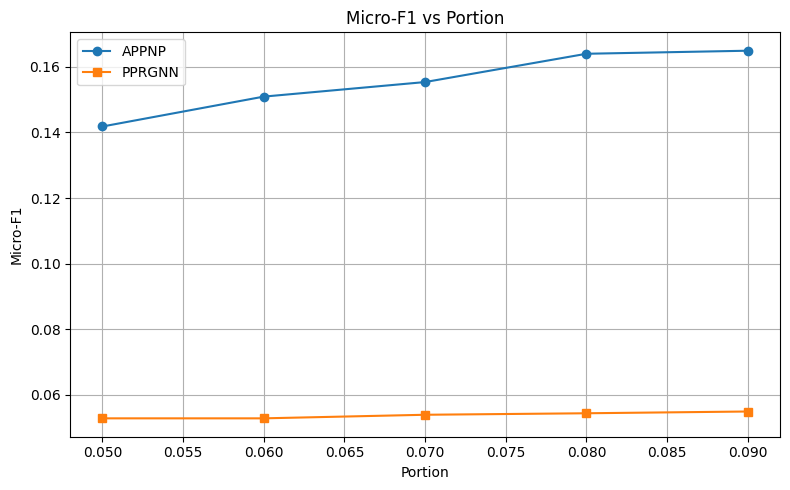

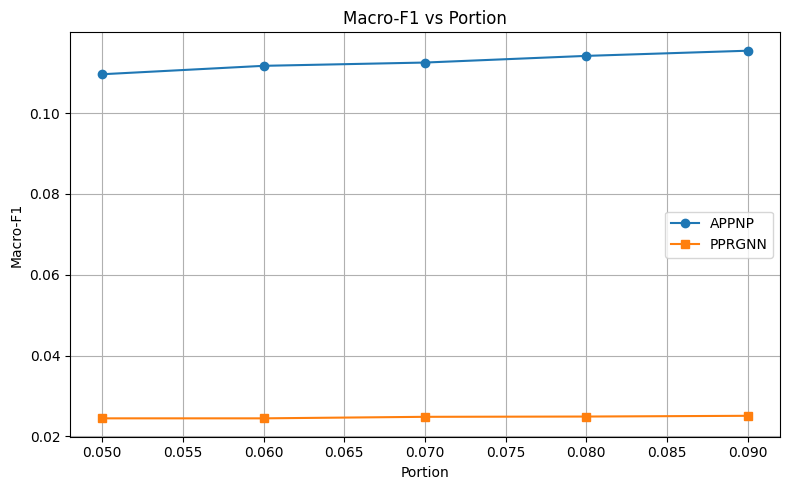

In [ ]:
import matplotlib.pyplot as plt

# Define the data
portions = [0.05, 0.06, 0.07, 0.08, 0.09]

# Micro-F1 scores
appnp_micro_f1 = [0.141830, 0.15095, 0.155393, 0.1640293, 0.16496]
pprgnn_micro_f1 = [0.05274854825, 0.05274854, 0.053839987, 0.05429667704336, 0.0548360]

# Macro-F1 scores
appnp_macro_f1 = [0.109599, 0.11168, 0.112491, 0.11414, 0.115418]
pprgnn_macro_f1 = [0.02446328, 0.02446328, 0.02484, 0.0249078343, 0.0250913]



# Plotting function
def plot_metric(y_appnp, y_pprgnn, metric_name):
    plt.figure(figsize=(8, 5))
    plt.plot(portions, y_appnp, label='APPNP', marker='o')
    plt.plot(portions, y_pprgnn, label='PPRGNN', marker='s')
    plt.title(f'{metric_name} vs Portion')
    plt.xlabel('Portion')
    plt.ylabel(metric_name)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Generate the plots
plot_metric(appnp_micro_f1, pprgnn_micro_f1, 'Micro-F1')
plot_metric(appnp_macro_f1, pprgnn_macro_f1, 'Macro-F1')

